Import Tools and Libraries

In [5]:
import numpy as numpy
import pandas as pd 
import os
import tensorflow as tf
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [6]:
#NLP
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
plt.rcParams['font.size'] = 12
sns.set_style('dark')
warnings.filterwarnings('ignore')

Read Dataset

In [9]:
image_path = 'Images'
df = pd.read_csv('captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [16]:
image_read = os.listdir(image_path)
image_read

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg',
 '101654506_8eb26cfb60.jpg',
 '101669240_b2d3e7f17b.jpg',
 '1016887272_03199f49c4.jpg',
 '1019077836_6fc9b15408.jpg',
 '1019604187_d087bf9a5f.jpg',
 '1020651753_06077ec457.jpg',
 '1022454332_6af2c1449a.jpg',
 '1022454428_b6b660a67b.jpg',
 '1022975728_75515238d8.jpg',
 '102351840_323e3de834.jpg',
 '1024138940_f1fefbdce1.jpg',
 '102455176_5f8ead62d5.jpg',
 '1026685415_0431cbf574.jpg',
 '1028205764_7e8df9a2ea.jpg',
 '1030985833_b0902ea560.jpg',
 '103106960_e8a41d64f8.jpg',
 '103195344_5d2dc613a3.jpg',
 '103205630_682ca7285b.jpg',
 '1032122270_ea6f0beedb.jpg',
 '1032460886_4a598ed535.jpg',
 '1034276567_49bb87c51c.jpg',
 '104136873_5b5d41be75.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '1042590306_95dea

In [33]:
img_size = 224

def readImage(path, img_size):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    return img

In [38]:
def display_image(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5,5, n)
        plt.subplots_adjust(hspace= 0.7, wspace=0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}", img_size)
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i], 20)))
        plt.axis('off')



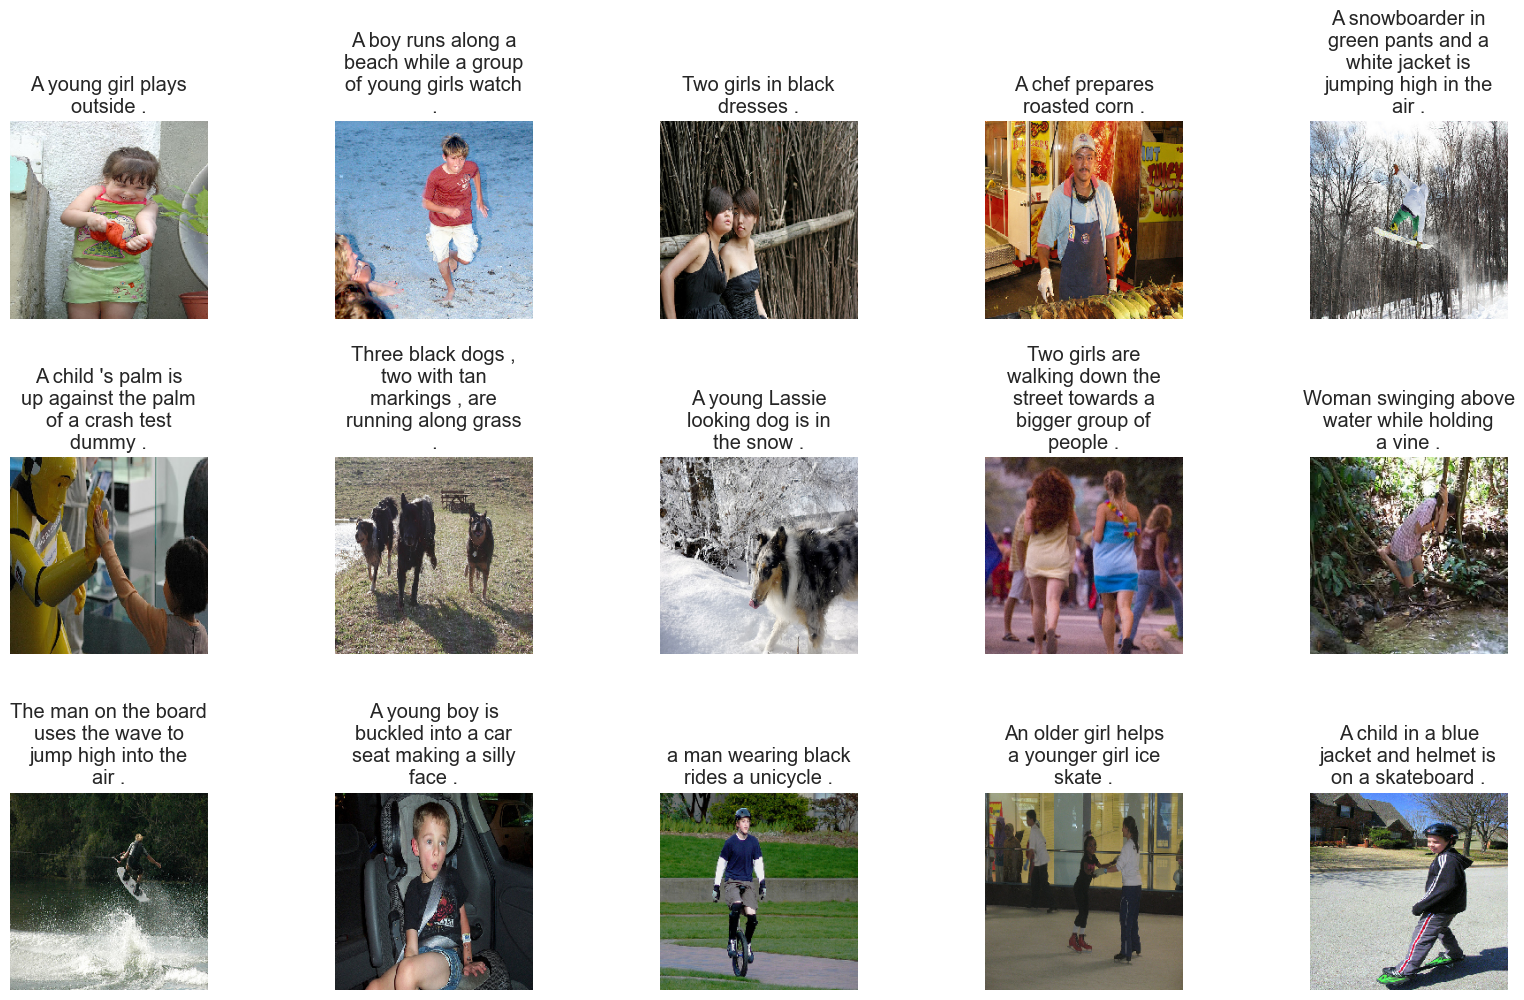

In [39]:
display_image(df.sample(15))

In [40]:
def text_preprocessing(df):
    df['caption'] = df['caption'].apply(lambda x: x.lower())
    df['caption'] = df['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    df['caption'] = df['caption'].apply(lambda x: x.replace("\s+", " "))
    df['caption'] = df['caption'].apply(
        lambda x: " ".join([word for word in x.split() if len(word) > 1])
    )
    
    df['caption'] = "startseq " + df['caption'] + " endseq"
    return df

df = text_preprocessing(df)
captions = df['caption'].tolist()
captions[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) +1

max_length = max([len(caption.split()) for caption in captions])

images = df['image'].unique ().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = df[df['image'].isin(train_images)]
tokenizer.texts_to_sequences([captions[10]])
nimages

34